### Dataset loader for the deep learning model training.

In [ ]:
import torch
import glob
import rasterio as rio
import numpy as np 
import random
from utils.imgShow import imsShow


In [3]:
paths_truth = sorted(glob.glob('data/dset/truth/*.tif'))
random.shuffle(paths_truth, random.seed(1))  # Set a seed for reproducibility
paths_scene = [path.replace('.tif', '.tif').replace('truth','scene') for path in paths_truth]
paths_dem = [path.replace('.tif', '_dem.tif').replace('truth','dem') for path in paths_truth]
## split the dataset into training and validation sets
## validation set (13 scenes)
paths_truth_val = paths_truth[:13]
paths_scene_val = paths_scene[:13]
paths_dem_val = paths_dem[:13]
## Training set (remaining scenes)
paths_truth_tra = paths_truth[13:]
paths_scene_tra = paths_scene[13:]
paths_dem_tra = paths_dem[13:]
len(paths_scene_val)


13

In [ ]:
## create related functions
## - crop scene to patches
class crop:
    '''randomly crop corresponding to specific patch size'''
    def __init__(self, size=(256,256)):
        self.size = size
    def __call__(self, image, truth):
        '''size: (height, width)'''
        start_h = random.randint(0, truth.shape[0]-self.size[0])
        start_w = random.randint(0, truth.shape[1]-self.size[1])
        patch = image[:,start_h:start_h+self.size[0],start_w:start_w+self.size[1]]
        truth = truth[start_h:start_h+self.size[0], start_w:start_w+self.size[1]]
        return patch, truth
class Normalize:
    def __init__(self, max_bands, min_bands):
        self.max = max_bands  
        self.min = min_bands          
    def __call__(self, image):
        if isinstance(self.max, (int, float)):
            self.max = [self.max] * image.shape[-1]  
        if isinstance(self.min, (int, float)):
            self.min = [self.min] * image.shape[-1]         
        normalized = []
        for b in range(image.shape[-1]):  
            band = image[:, :, b].astype(float)  # 
            band_norm = (band - self.min[b]) / (self.max[b] - self.min[b] + 1e-6)
            normalized.append(band_norm)  
        normalized = np.stack(normalized, axis=-1)  
        return np.clip(normalized, 0.0, 1.0)  

In [5]:
### - Dataset definition
class Dataset(torch.utils.data.Dataset):
    def __init__(self, paths_scene, paths_truth, paths_dem=None):
        self.paths_scene = paths_scene
        self.paths_truth = paths_truth
        self.paths_dem = paths_dem
    def __getitem__(self, idx):
        # Load scene and truth image
        scene_path = self.paths_scene[idx]
        truth_path = self.paths_truth[idx]
        ## read scene and truth images
        with rio.open(scene_path) as src:
            scene_arr = src.read().transpose((1, 2, 0))  # (H, W, C)
        ## scene normalization
        if 's2_scene' in scene_path: scene_arr = scene_arr / 10000  # scale to [0, 1] if needed, adjust based on your data
        else: scene_arr = scene_arr/ 65455  # scale to [0, 1] if needed, adjust based on your data
        with rio.open(truth_path) as truth_src:
            truth_arr = truth_src.read(1)  # (H, W)
        ## read dem
        if self.paths_dem is not None:
            dem_path = self.paths_dem[idx]
            with rio.open(dem_path) as dem_src:
                dem_arr = dem_src.read(1)  # (H, W)
            dem_arr = dem_arr[:, :, np.newaxis]  # expand to (H, W, 1)
            ## dem normalization
            dem_arr = dem_arr / 8848  # scale to [0, 1] if needed, adjust based on your data 
        scene_arr = np.concatenate([scene_arr, dem_arr], axis=-1)  # (H, W, C+1)
        scene_arr = scene_arr.astype(np.float32).transpose((2, 0, 1))
        patch, truth = crop(size=(512, 512))(scene_arr, truth_arr)  # crop
        truth = truth[np.newaxis, :].astype(np.float32)  # (1, H, W)
        patch = torch.from_numpy(patch).float()
        truth = torch.from_numpy(truth).float()
        return patch, truth
    def __len__(self):
        return len(self.paths_scene)


In [6]:
## Create dataset instances
tra_data = Dataset(paths_scene=paths_scene_tra, paths_truth=paths_truth_tra, paths_dem=paths_dem_tra)
val_data = Dataset(paths_scene=paths_scene_val, paths_truth=paths_truth_val, paths_dem=paths_dem_val)


torch.Size([7, 512, 512]) torch.Size([1, 512, 512])
training data size: 52
validation data size: 13


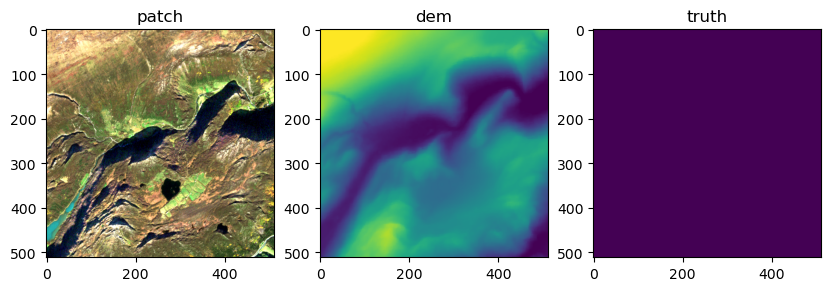

In [7]:
patch, truth = tra_data[0]
scene, dem = patch[:-1], patch[-1]  # last channel is dem
print(patch.shape, truth.shape)
print('training data size:',len(tra_data))
print('validation data size:', len(val_data))
imsShow([scene.numpy().transpose((1, 2, 0)), dem.numpy(), truth[0].numpy()], 
              clip_list=[2,2,2], img_name_list=['patch','dem','truth'], figsize=(10, 3))


In [8]:
### Create DataLoader
tra_loader = torch.utils.data.DataLoader(tra_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4)


torch.Size([4, 7, 512, 512]) torch.Size([4, 1, 512, 512])


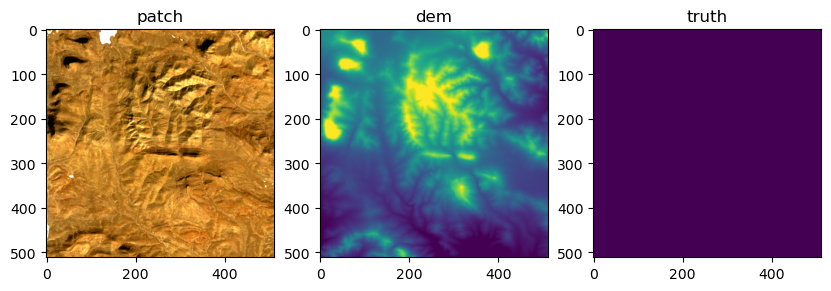

In [9]:
# for patch, truth in tra_loader:
#     print(patch.shape)
batch_patch, batch_truth = next(iter(tra_loader))
print(batch_patch.shape, batch_truth.shape)
patch_arr = batch_patch[0].numpy().transpose((1, 2, 0))
dem_arr = batch_patch[0].numpy()[-1]
truth_arr = batch_truth[0].numpy().squeeze()
imsShow([patch_arr, dem_arr, truth_arr], img_name_list=['patch', 'dem', 'truth'], 
                     clip_list=[2,2,2], figsize=(10, 3))
